In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.manifold import MDS
from PIL import Image
import os
import pingouin as pg
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import orthogonal_procrustes
from nltk.corpus import wordnet as wn
import json
import pickle
import gc

import ecoset
import categorization as cat
import train
import utils

# Seed for reproducibility
np.random.seed(2023)
tf.random.set_seed(2023)

# Use category specific reps
useCatReps = False


def clear_model():
    # Check if model variable exists
    if "model" in globals():
        del globals()["model"]
        tf.keras.backend.clear_session()
        gc.collect()

2023-08-30 17:39:07.820665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 17:39:10.930367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-30 17:39:10.930488: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-30 17:39:10.930500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Dataset

800 images from imagenet + CUB200.

- Superordinate: 400 vehicles and 400 animals
- Basic: 200 cars, 200 busses, 200 dogs, 200 birds
- Subordinate: 40 per species of birds

Half of these images are from the training set (therefore we'll use it as category knowledge). The other half are from the Train/validation set, so we'll use them in the categorization test.

Images preprocessed by centering the features and resizing to 224x224.


In [2]:
# Load csv
trainCatImgs = pd.read_csv("./deepCatsTrainImages.csv")

# Rename cat columns
trainCatImgs = trainCatImgs.rename(
    columns={
        "cat1": "super",
        "cat2": "basic",
        "cat3": "sub",
    }
)

# Add a column delineating train/test set
trainCatImgs["set"] = "train"

trainCatImgs.head()

,path,name,super,basic,sub,set
0,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0030_130191.jpg,animal,bird,CUB_136.Barn_Swallow,train
1,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0065_131555.jpg,animal,bird,CUB_136.Barn_Swallow,train
2,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0060_130110.jpg,animal,bird,CUB_136.Barn_Swallow,train
3,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0042_132043.jpg,animal,bird,CUB_136.Barn_Swallow,train
4,./images/deepCats/train/animal/bird/CUB_136.Ba...,Barn_Swallow_0016_130678.jpg,animal,bird,CUB_136.Barn_Swallow,train


In [3]:
trainImgFile = "./images/deepCatsTrainImages.npy"

if not os.path.exists(trainImgFile):
    # Preallocate array for images
    trainImages = np.zeros((trainCatImgs.shape[0], 224, 224, 3), dtype=np.float32)

    # Loop through images
    for i, row in trainCatImgs.iterrows():
        # Load image
        img = Image.open(row["path"])

        # Preprocess image
        img = ecoset.preprocess_alexnet(img)

        # Add image to array
        trainImages[i] = img

    # Save images as a npy
    np.save(trainImgFile, trainImages)
else:
    # Load images from npy
    print("Loading images from file...")
    trainImages = np.load(trainImgFile)

print(trainImages.shape)

Loading images from file...
(400, 224, 224, 3)


In [4]:
# Load csv
testCatImgs = pd.read_csv("./deepCatsTestImages.csv")

# Rename cat columns
testCatImgs = testCatImgs.rename(
    columns={
        "cat1": "super",
        "cat2": "basic",
        "cat3": "sub",
    }
)

# Add a column delineating train/test set
testCatImgs["set"] = "test"

testCatImgs.head()

,path,name,super,basic,sub,set
0,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0038_132780.jpg,animal,bird,CUB_136.Barn_Swallow,test
1,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0052_131539.jpg,animal,bird,CUB_136.Barn_Swallow,test
2,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0022_130631.jpg,animal,bird,CUB_136.Barn_Swallow,test
3,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0003_130086.jpg,animal,bird,CUB_136.Barn_Swallow,test
4,./images/deepCats/test/animal/bird/CUB_136.Bar...,Barn_Swallow_0023_130325.jpg,animal,bird,CUB_136.Barn_Swallow,test


In [5]:
testImgFile = "./images/deepCatsTestImages.npy"

if not os.path.exists(testImgFile):
    # Preallocate array for images
    testImages = np.zeros((testCatImgs.shape[0], 224, 224, 3), dtype=np.float32)

    # Loop through images
    for i, row in testCatImgs.iterrows():
        # Load image
        img = Image.open(row["path"])

        # Preprocess image
        img = ecoset.preprocess_alexnet(img)

        # Add image to array
        testImages[i] = img

    # Save images as a npy
    np.save(testImgFile, testImages)
else:
    # Load images from npy
    print("Loading images from file...")
    testImages = np.load(testImgFile)

print(testImages.shape)

Loading images from file...
(400, 224, 224, 3)


# Models and representations

Generate representations from AlexNet trained in Mehrer et al 2022.

- 10 models are trained on Ecoset (basic-level categories)
- 10 models are trained on ImageNet (mixed levels of abstraction)


In [6]:
# Load example model
weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89"
model = ecoset.make_alex_net_v2(weights_path=weightPath)
model.summary()

2023-08-30 17:36:45.805618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-30 17:36:45.909724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-30 17:36:45.910472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-30 17:36:45.919879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Weights from ./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_01/model.ckpt_epoch89 loaded successfully.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 54, 54, 64)        23296     
                                                                 
 pool1 (MaxPooling2D)        (None, 26, 26, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 26, 26, 192)       307392    
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 192)       0         
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 384)       663936    
         

In [7]:
# Nodes of interest for ecoset
ecosetCatNodes = {"dog": 8, "bird": 25, "car": 2, "bus": 27}

In [8]:
# Get fc8 weights
fc8 = model.get_layer("fc8")
fc8 = fc8.get_weights()[0]

# Squeeze
fc8 = np.squeeze(fc8)

# Get median
fc8Med = np.median(fc8)

# Get range of fc8 weights
np.min(fc8), np.max(fc8)

(-0.07009344, 0.11153594)

In [9]:
# Dog weight indices
dogWeights = fc8[:, ecosetCatNodes["dog"]]
ecosetDogIdxs = np.where(dogWeights > 0)[0]
ecosetDogIdxs.shape

(2070,)

In [10]:
# Bird weight indices
birdWeights = fc8[:, ecosetCatNodes["bird"]]
ecosetBirdIdxs = np.where(birdWeights > 0)[0]
ecosetBirdIdxs.shape

(2012,)

In [11]:
# Car weight indices
carWeights = fc8[:, ecosetCatNodes["car"]]
ecosetCarIdxs = np.where(carWeights > 0)[0]
ecosetCarIdxs.shape

(1701,)

In [12]:
# Bus weight indices
busWeights = fc8[:, ecosetCatNodes["bus"]]
ecosetBusIdxs = np.where(busWeights > fc8Med)[0]
ecosetBusIdxs.shape

(1632,)

In [13]:
# Create a dictionary of idxs for each category
ecosetIdxs = {
    "animal": [ecosetDogIdxs, ecosetBirdIdxs],
    "vehicle": [ecosetCarIdxs, ecosetBusIdxs],
    "dog": [ecosetDogIdxs],
    "bird": [ecosetBirdIdxs],
    "car": [ecosetCarIdxs],
    "bus": [ecosetBusIdxs],
    "CUB_002.Laysan_Albatross": [ecosetBirdIdxs],
    "CUB_048.European_Goldfinch": [ecosetBirdIdxs],
    "CUB_094.White_breasted_Nuthatch": [ecosetBirdIdxs],
    "CUB_136.Barn_Swallow": [ecosetBirdIdxs],
    "CUB_199.Winter_Wren": [ecosetBirdIdxs],
}

# Pickle
with open("ecosetIdxs.pkl", "wb") as f:
    pickle.dump(ecosetIdxs, f)

In [14]:
def find_nested_synsets(targetSynset, synsets):
    """
    Return the index and synsets from the list synsets that is nested under
    the targetSynset
    """
    nestedIdxs, nestedSynsets = [], []
    for i, synset in enumerate(synsets):
        lowest_common_hypernyms = synset.lowest_common_hypernyms(targetSynset)
        if targetSynset in lowest_common_hypernyms:
            nestedIdxs.append(i)
            nestedSynsets.append(synset)

    return nestedIdxs, nestedSynsets

In [15]:
# Load imagenet class index
with open("./imagenet_class_index.json", "r") as f:
    imagenetCats = json.load(f)

imagenetSynsets = [
    wn.synset_from_pos_and_offset("n", int(value[0][1:]))
    for value in imagenetCats.values()
]

# Superordinate
imagenetAnimalIdxs, animalSynsets = find_nested_synsets(
    wn.synset("animal.n.01"), imagenetSynsets
)
imagenetVehicleIdxs, vehicleSynsets = find_nested_synsets(
    wn.synset("vehicle.n.01"), imagenetSynsets
)

# Basic
imagenetDogIdxs, dogSynsets = find_nested_synsets(
    wn.synset("dog.n.01"), imagenetSynsets
)
imagenetBirdIdxs, birdSynsets = find_nested_synsets(
    wn.synset("bird.n.01"), imagenetSynsets
)
imagenetCarIdxs, carSynsets = find_nested_synsets(
    wn.synset("car.n.01"), imagenetSynsets
)
imagenetBusIdxs, busSynsets = find_nested_synsets(
    wn.synset("bus.n.01"), imagenetSynsets
)

# Sub is just the basic ones

In [16]:
imagenetIdxs = {
    "animal": [imagenetAnimalIdxs],
    "vehicle": [imagenetVehicleIdxs],
    "bird": [imagenetBirdIdxs],
    "dog": [imagenetDogIdxs],
    "car": [imagenetCarIdxs],
    "bus": [imagenetBusIdxs],
    "CUB_002.Laysan_Albatross": [imagenetBirdIdxs],
    "CUB_048.European_Goldfinch": [imagenetBirdIdxs],
    "CUB_094.White_breasted_Nuthatch": [imagenetBirdIdxs],
    "CUB_136.Barn_Swallow": [imagenetBirdIdxs],
    "CUB_199.Winter_Wren": [imagenetBirdIdxs],
}

In [17]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Get ecoset representations
ecosetTrainReps = np.zeros(
    (len(seeds), trainImages.shape[0], 5, 5, 4096), dtype=np.float32
)
for i, seed in enumerate(seeds):
    repFile = f"./representations/ecoset/seed{seed:02}_train_reps.npy"

    if not os.path.exists(repFile):
        # Cleanup so we don't run out of GPU memory
        clear_model()

        # Load model
        weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(trainImages)
        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    ecosetTrainReps[i] = reps

ecosetTrainReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 400, 5, 5, 4096)

In [18]:
# Get imagenet representations
imagenetTrainReps = np.zeros(
    (len(seeds), trainImages.shape[0], 5, 5, 4096), dtype=np.float32
)
for i, seed in enumerate(seeds):
    repFile = f"./representations/imagenet/seed{seed:02}_train_reps.npy"

    if not os.path.exists(repFile):
        # Cleanup so we don't run out of GPU memory
        clear_model()

        # Load model
        weightPath = f"./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath, output_shape=1000)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(trainImages)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    imagenetTrainReps[i] = reps

imagenetTrainReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 400, 5, 5, 4096)

In [19]:
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Get ecoset representations
ecosetTestReps = np.zeros(
    (len(seeds), testImages.shape[0], 5, 5, 4096), dtype=np.float32
)
for i, seed in enumerate(seeds):
    repFile = f"./representations/ecoset/seed{seed:02}_test_reps.npy"

    if not os.path.exists(repFile):
        # Cleanup so we don't run out of GPU memory
        clear_model()

        # Load model
        weightPath = f"./models/AlexNet/ecoset_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(testImages)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    ecosetTestReps[i] = reps

ecosetTestReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...
Loading representations from file for seed 10...


(10, 400, 5, 5, 4096)

In [20]:
# Get imagenet representations
imagenetTestReps = np.zeros(
    (len(seeds), testImages.shape[0], 5, 5, 4096), dtype=np.float32
)
for i, seed in enumerate(seeds):
    repFile = f"./representations/imagenet/seed{seed:02}_test_reps.npy"

    if not os.path.exists(repFile):
        # Cleanup so we don't run out of GPU memory
        clear_model()

        # Load model
        weightPath = f"./models/AlexNet/ILSVRC_training_seeds_01_to_10/training_seed_{seed:02}/model.ckpt_epoch89"
        model = ecoset.make_alex_net_v2(weights_path=weightPath, output_shape=1000)

        # Get activation from penultimate layer
        layer = model.get_layer("fc7")
        model = tf.keras.Model(model.input, layer.output)

        # Get representations
        reps = model.predict(testImages)

        # Save representations
        np.save(repFile, reps)
    else:
        print(f"Loading representations from file for seed {seed:02}...")
        reps = np.load(repFile)

    # Add rep to big representation array
    imagenetTestReps[i] = reps

imagenetTestReps.shape

Loading representations from file for seed 01...
Loading representations from file for seed 02...
Loading representations from file for seed 03...
Loading representations from file for seed 04...
Loading representations from file for seed 05...
Loading representations from file for seed 06...
Loading representations from file for seed 07...
Loading representations from file for seed 08...
Loading representations from file for seed 09...


: 

: 

# Categorization

We use a LBA to simulate a category verification task where each model is a
different participant. We perform the task in each level of abstraction. For
each image, we calculate a drift rate to verify that that image belongs to its
category by calculating similarity of that image's representation with the
similarity of every other image of the same category (GCM-like).


In [ ]:
criterion = [11, 9]
maxImgs = 20

performanceFile = f"./cat_performance"
if useCatReps:
    performanceFile += "_catReps"
performanceFile += ".csv"
if not os.path.exists(performanceFile):
    performance = pd.DataFrame(
        columns=[
            "seed",
            "model",
            "image",
            "category",
            "level",
            "response",
            "RT",
            "crit",
            "maxImgs",
        ]
    )
    for level in ["super", "basic", "sub"]:
        performance = pd.concat(
            [
                performance,
                cat.simulate_cat_verification(
                    testReps=ecosetTestReps,
                    memoryReps=ecosetTrainReps,
                    testImgInfo=testCatImgs,
                    memoryImgInfo=trainCatImgs,
                    categoryCol=level,
                    modelName="ecoset",
                    simFun=cat.gcm_sim,
                    criterion=criterion[0],
                    maxImgs=maxImgs,
                    catRepIdxs=ecosetIdxs if useCatReps else None,
                ),
            ]
        )

        performance = pd.concat(
            [
                performance,
                cat.simulate_cat_verification(
                    testReps=imagenetTestReps,
                    memoryReps=imagenetTrainReps,
                    testImgInfo=testCatImgs,
                    memoryImgInfo=trainCatImgs,
                    categoryCol=level,
                    modelName="imagenet",
                    simFun=cat.gcm_sim,
                    criterion=criterion[1],
                    maxImgs=maxImgs,
                    catRepIdxs=imagenetIdxs if useCatReps else None,
                ),
            ]
        )

    performance.to_csv(performanceFile, index=False)
else:
    print("Loading performance from file")
    performance = pd.read_csv(performanceFile)

print(
    performance.groupby(["model", "level"])["response"].agg(
        lambda x: np.mean(x == "yes")
    )
)
print(performance.groupby(["model", "level"])["RT"].agg(["mean", "std"]))

Loading performance from file
model     level
ecoset    basic    0.87725
          sub      0.98100
          super    0.76825
imagenet  basic    0.85850
          sub      0.96400
          super    0.74650
Name: response, dtype: float64
                    mean       std
model    level                    
ecoset   basic  0.971731  0.017857
         sub    0.969147  0.013624
         super  0.979847  0.014019
imagenet basic  0.945227  0.034160
         sub    0.957170  0.019041
         super  0.952808  0.029163


# ANOVA Analysis

We treat each model as a different participant so we do a mixed effects ANOVA where we have a between subject factor of training set (Ecoset or Imagenet) and a within-subject factor of level of categorization (Superordinate, basic, subordiante).


In [ ]:
# Add a subject column that is a combo of model and seed
performance["subject"] = performance["model"] + performance["seed"].astype(str)

# Group data by model and level
sbjData = (
    performance.groupby(["subject", "model", "level"])
    .agg({"response": [lambda x: np.mean(x == "yes")], "RT": ["mean"]})
    .reset_index()
)
sbjData.columns = sbjData.columns.droplevel(1)
sbjData = sbjData.rename(columns={"response": "accuracy", "RT": "RT"})
sbjData.head()

,subject,model,level,accuracy,RT
0,ecoset1,ecoset,basic,0.8775,0.971892
1,ecoset1,ecoset,sub,0.9800,0.968770
2,ecoset1,ecoset,super,0.7950,0.979511
3,ecoset10,ecoset,basic,0.8950,0.970902
4,ecoset10,ecoset,sub,0.9900,0.968078


In [ ]:
pg.mixed_anova(
    sbjData, dv="accuracy", within="level", between="model", subject="subject"
)

/data/venv/research2/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,model,0.005510,1,18,0.005510,7.484908,1.357564e-02,0.293700,NaN
1,level,0.462903,2,36,0.231451,977.151087,4.294402e-32,0.981912,0.624139
2,Interaction,0.000058,2,36,0.000029,0.121818,8.856731e-01,0.006722,NaN


In [ ]:
pg.mixed_anova(sbjData, dv="RT", within="level", between="model", subject="subject")

/data/venv/research2/lib/python3.8/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,model,0.007155,1,18,0.007155,2529.988500,8.153339e-21,0.992936,NaN
1,level,0.000624,2,36,0.000312,295.595759,4.573428e-23,0.942601,0.502786
2,Interaction,0.000730,2,36,0.000365,346.136670,3.105601e-24,0.950568,NaN


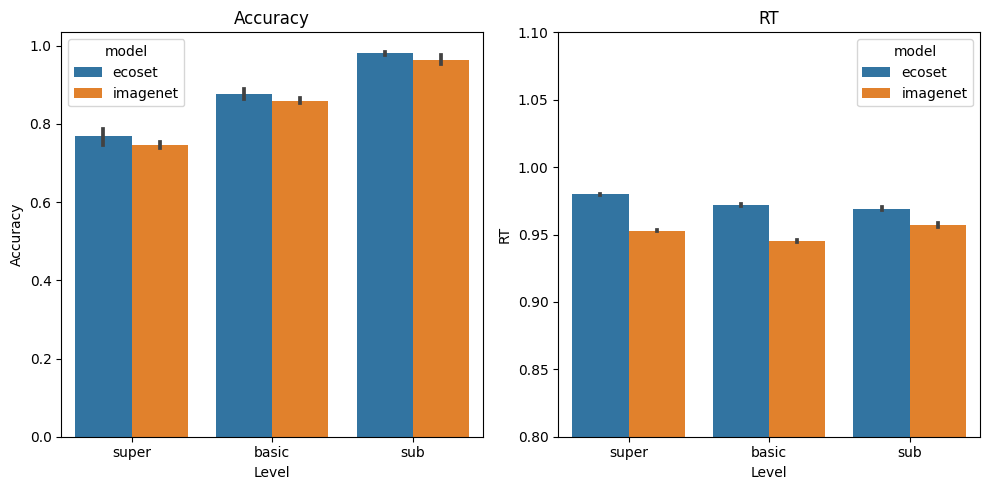

In [ ]:
# Plot accuracy and RT
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# Accuracy
sns.barplot(
    data=sbjData,
    x="level",
    y="accuracy",
    hue="model",
    ax=ax[0],
    order=["super", "basic", "sub"],
)
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Level")
ax[0].set_ylabel("Accuracy")

# RT
sns.barplot(
    data=sbjData,
    x="level",
    y="RT",
    hue="model",
    ax=ax[1],
    order=["super", "basic", "sub"],
)
# Set y range
ax[1].set_ylim(0.8, 1.1)
ax[1].set_title("RT")
ax[1].set_xlabel("Level")
ax[1].set_ylabel("RT")

plt.tight_layout()
plt.show()

# MDS Analysis

We now look at how the categories are represented in the representational space.


In [ ]:
ecosetImgSimMatFile = "./representations/ecoset_img_sim_mat.npy"

if not os.path.exists(ecosetImgSimMatFile):
    # Concatenate representations between train and test
    ecosetReps = np.concatenate((ecosetTrainReps, ecosetTestReps), axis=1)
    ecosetSimMat = np.zeros(
        (len(seeds), ecosetReps.shape[1], ecosetReps.shape[1]), dtype=np.float32
    )
    for i in range(len(seeds)):
        ecosetSimMat[i] = squareform(pdist(ecosetReps[i], metric=cat.gcm_sim))

    np.save(ecosetImgSimMatFile, ecosetSimMat)
    del ecosetReps
else:
    ecosetSimMat = np.load(ecosetImgSimMatFile)


ecosetSimMat = np.mean(ecosetSimMat, axis=0)
# Set diagonal to 1
np.fill_diagonal(ecosetSimMat, 1)
ecosetSimMat.shape

(800, 800)

In [ ]:
imagenetImgSimMatFile = "./representations/imagenet_img_sim_mat.npy"

if not os.path.exists(imagenetImgSimMatFile):
    imagenetReps = np.concatenate((imagenetTrainReps, imagenetTestReps), axis=1)
    imagenetSimMat = np.zeros(
        (len(seeds), imagenetReps.shape[1], imagenetReps.shape[1]), dtype=np.float32
    )
    for i in range(len(seeds)):
        imagenetSimMat[i] = squareform(pdist(imagenetReps[i], metric=cat.gcm_sim))

    np.save(imagenetImgSimMatFile, imagenetSimMat)

    imagenetReps = np.concatenate((imagenetTrainReps, imagenetTestReps), axis=1)
    del imagenetReps
else:
    imagenetSimMat = np.load(imagenetImgSimMatFile)

imagenetSimMat = np.mean(imagenetSimMat, axis=0)
# Set diagonal to 1
np.fill_diagonal(ecosetSimMat, 1)
imagenetSimMat.shape

(800, 800)

In [ ]:
# Clean up rep arrays for memory
del ecosetTrainReps
del ecosetTestReps
del imagenetTrainReps
del imagenetTestReps

In [ ]:
# Turn similarity matrices to distance matrices
ecosetDistMat = 1 - ecosetSimMat
imagenetDistMat = 1 - imagenetSimMat

eps = 1e-3
metric = True

# Create MDS for Ecoset
ecosetMDS = MDS(
    n_components=2,
    dissimilarity="precomputed",
    normalized_stress="auto",
    metric=metric,
    eps=eps,
    n_init=10,
)
ecosetSolution = ecosetMDS.fit_transform(ecosetDistMat)
print(ecosetMDS.stress_)

# Create MDS for Imagenet
imagenetMDS = MDS(
    n_components=2,
    dissimilarity="precomputed",
    normalized_stress="auto",
    metric=metric,
    eps=eps,
    n_init=10,
)
imagenetSolution = imagenetMDS.fit_transform(imagenetDistMat)
print(imagenetMDS.stress_)

ecosetSolution.shape

9171.52419002821
13221.68435569934


(800, 2)

In [ ]:
# Concatenate df for both train and test images
catImgs = pd.concat([trainCatImgs, testCatImgs], axis=0)
# Reset index
catImgs = catImgs.reset_index(drop=True)

# Color mapping
colorMap = {
    "bird": sns.color_palette(n_colors=4)[0],
    "dog": sns.color_palette(n_colors=4)[1],
    "car": sns.color_palette(n_colors=4)[2],
    "bus": sns.color_palette(n_colors=4)[3],
}
colors = list(catImgs["basic"].map(colorMap))
# Market mapping
markerMap = {
    float("nan"): "o",
    "CUB_002.Laysan_Albatross": "s",
    "CUB_048.European_Goldfinch": "s",
    "CUB_094.White_breasted_Nuthatch": "p",
    "CUB_136.Barn_Swallow": "P",
    "CUB_199.Winter_Wren": "*",
}
markers = list(catImgs["sub"].map(markerMap))

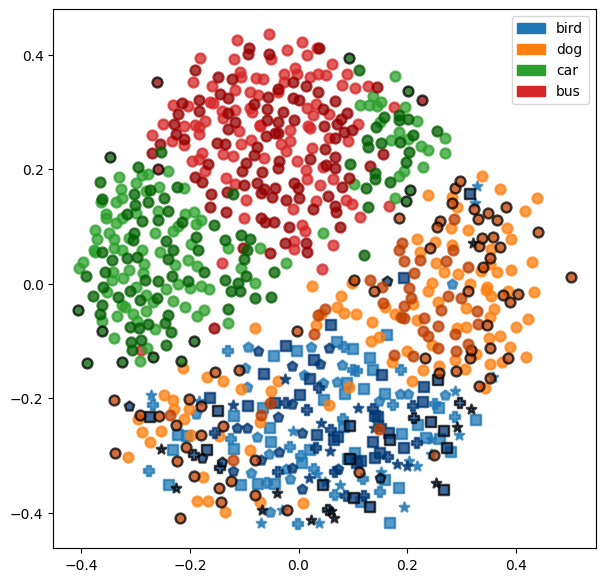

In [ ]:
# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Plot MDS
for i, row in catImgs.iterrows():
    edgecolors = None
    color = colors[i]
    if row["set"] == "test":
        color = [c - 0.25 if c - 0.25 > 0 else 0 for c in color]
        logIdx = (
            (performance["model"] == "ecoset")
            & (performance["image"] == row["name"])
            & (performance["level"] == "basic")
        )
        noResponses = performance.loc[logIdx]["response"].values == "no"
        if np.any(noResponses):
            edgecolors = "k"

    ax.scatter(
        ecosetSolution[i, 0],
        ecosetSolution[i, 1],
        s=50,
        color=color,
        marker=markers[i],
        edgecolors=edgecolors,
        alpha=0.75,
        linewidths=1.75,
    )

legendHandles = [
    mpatches.Patch(color=colorMap["bird"], label="bird"),
    mpatches.Patch(color=colorMap["dog"], label="dog"),
    mpatches.Patch(color=colorMap["car"], label="car"),
    mpatches.Patch(color=colorMap["bus"], label="bus"),
]
ax.legend(handles=legendHandles, loc="upper right")

fig.show()

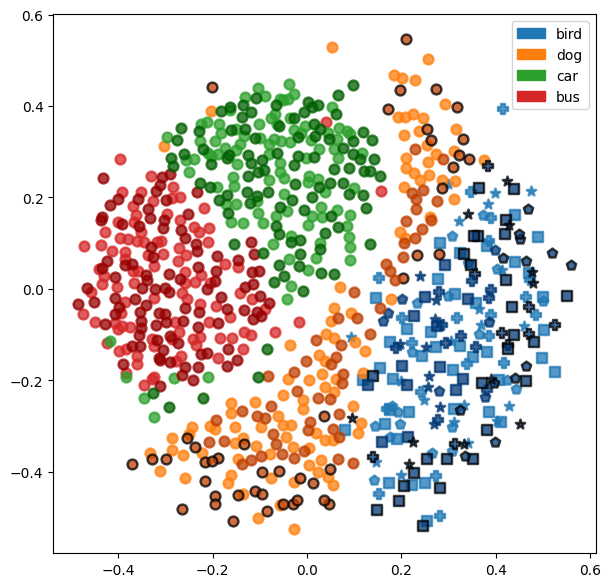

In [ ]:
# Plot MDS
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# Plot MDS
for i, row in catImgs.iterrows():
    edgecolors = None
    color = colors[i]
    if row["set"] == "test":
        color = [c - 0.25 if c - 0.25 > 0 else 0 for c in color]
        logIdx = (
            (performance["model"] == "imagenet")
            & (performance["image"] == row["name"])
            & (performance["level"] == "basic")
        )
        noResponses = performance.loc[logIdx]["response"].values == "no"
        if np.any(noResponses):
            edgecolors = "k"

    ax.scatter(
        imagenetSolution[i, 0],
        imagenetSolution[i, 1],
        s=50,
        color=color,
        marker=markers[i],
        edgecolors=edgecolors,
        alpha=0.75,
        linewidths=1.75,
    )

legendHandles = [
    mpatches.Patch(color=colorMap["bird"], label="bird"),
    mpatches.Patch(color=colorMap["dog"], label="dog"),
    mpatches.Patch(color=colorMap["car"], label="car"),
    mpatches.Patch(color=colorMap["bus"], label="bus"),
]
ax.legend(handles=legendHandles, loc="upper right")

fig.show()

# Cluster Indices

Now we calculate cluster indices.

$ cluster index = MeanWithinCategorySimilarity - MeanBetweenCategorySimilarity $

Because we are using GCM for similarity (bounded 0 to 1):

+1 means the category is perfectly clustered with the non-category exemplars really far away.

-1 means the category is really far away from each other with non-category exemplars perfectly clustered.

0 means that the category and non-category exemplars are equally well clustered (so it's probably random)


In [ ]:
levelMap = {
    "super": ["animal", "vehicle"],
    "basic": ["bird", "dog", "car", "bus"],
    "sub": [
        "CUB_002.Laysan_Albatross",
        "CUB_048.European_Goldfinch",
        "CUB_094.White_breasted_Nuthatch",
        "CUB_136.Barn_Swallow",
        "CUB_199.Winter_Wren",
    ],
}

ecosetSimCluster = {}
for imgSet in ["train", "test"]:
    simMat = ecosetSimMat
    for level in ["super", "basic", "sub"]:
        for category in levelMap[level]:
            cluster = cat.cluster_index(catImgs, level, category, imgSet, simMat)
            # print(f"{imgSet} {model} {level} {category} cluster: {cluster}")
            ecosetSimCluster[imgSet + "-" + category] = cluster

ecosetSimCluster

{'train-animal': 0.038464808926158556,
 'train-vehicle': 0.06735924723694231,
 'train-bird': 0.044189350299793095,
 'train-dog': 0.0348149929765198,
 'train-car': 0.06413587241982566,
 'train-bus': 0.08426881223450411,
 'train-CUB_002.Laysan_Albatross': 0.04710838617070723,
 'train-CUB_048.European_Goldfinch': 0.05983624771629514,
 'train-CUB_094.White_breasted_Nuthatch': 0.05567204965964745,
 'train-CUB_136.Barn_Swallow': 0.04775969369631061,
 'train-CUB_199.Winter_Wren': 0.06042306616902349,
 'test-animal': 0.03465101841673557,
 'test-vehicle': 0.06429892310961782,
 'test-bird': 0.04595397649732502,
 'test-dog': 0.030169469788851155,
 'test-car': 0.051302320282176295,
 'test-bus': 0.079238831380401,
 'test-CUB_002.Laysan_Albatross': 0.03913262618215463,
 'test-CUB_048.European_Goldfinch': 0.06003257320899713,
 'test-CUB_094.White_breasted_Nuthatch': 0.057526929802016125,
 'test-CUB_136.Barn_Swallow': 0.057510597380368345,
 'test-CUB_199.Winter_Wren': 0.06131655098184163}

In [ ]:
ecosetSuperTrainCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "train"
]
ecosetSuperTrainCluster = np.mean(ecosetSuperTrainCluster)
ecosetSuperTestCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "test"
]
ecosetSuperTestCluster = np.mean(ecosetSuperTestCluster)

ecosetBasicTrainCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "train"
]
ecosetBasicTrainCluster = np.mean(ecosetBasicTrainCluster)
ecosetBasicTestCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "test"
]
ecosetBasicTestCluster = np.mean(ecosetBasicTestCluster)

ecosetSubTrainCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "train"
]
ecosetSubTrainCluster = np.mean(ecosetSubTrainCluster)
ecosetSubTestCluster = [
    value
    for key, value in ecosetSimCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "test"
]
ecosetSubTestCluster = np.mean(ecosetSubTestCluster)

print(f"Ecoset Cluster Indices:")
print(f"Super train cluster index: {ecosetSuperTrainCluster}")
print(f"Basic train cluster index: {ecosetBasicTrainCluster}")
print(f"Sub train cluster index: {ecosetSubTrainCluster}")
print("")
print(f"Super test cluster index: {ecosetSuperTestCluster}")
print(f"Basic test cluster index: {ecosetBasicTestCluster}")
print(f"Sub test cluster index: {ecosetSubTestCluster}")

Ecoset Cluster Indices:
Super train cluster index: 0.05291202808155043
Basic train cluster index: 0.056852256982660665
Sub train cluster index: 0.05415988868239678

Super test cluster index: 0.049474970763176696
Basic test cluster index: 0.05166614948718837
Sub test cluster index: 0.05510385551107557


In [ ]:
imagenetSimCluster = {}
for imgSet in ["train", "test"]:
    simMat = imagenetSimMat
    for level in ["super", "basic", "sub"]:
        for category in levelMap[level]:
            cluster = cat.cluster_index(catImgs, level, category, imgSet, simMat)
            # print(f"{imgSet} {model} {level} {category} cluster: {cluster}")
            imagenetSimCluster[imgSet + "-" + category] = cluster

imagenetSimCluster

{'train-animal': 0.006620624391622254,
 'train-vehicle': 0.08523127703335714,
 'train-bird': 0.02980502626664111,
 'train-dog': 0.021160840890654398,
 'train-car': 0.08309206420041698,
 'train-bus': 0.09035651736900663,
 'train-CUB_002.Laysan_Albatross': 0.0521808401652073,
 'train-CUB_048.European_Goldfinch': 0.0710251464733952,
 'train-CUB_094.White_breasted_Nuthatch': 0.05730374304479674,
 'train-CUB_136.Barn_Swallow': 0.04748941621890196,
 'train-CUB_199.Winter_Wren': 0.06326867009464066,
 'test-animal': 0.00310241426835256,
 'test-vehicle': 0.08465304277381258,
 'test-bird': 0.03398537213025671,
 'test-dog': 0.017737006783906883,
 'test-car': 0.0724108935760428,
 'test-bus': 0.08958456819138738,
 'test-CUB_002.Laysan_Albatross': 0.048329332255219126,
 'test-CUB_048.European_Goldfinch': 0.06563047970203972,
 'test-CUB_094.White_breasted_Nuthatch': 0.06862099807905525,
 'test-CUB_136.Barn_Swallow': 0.05816596911926014,
 'test-CUB_199.Winter_Wren': 0.06780027291100282}

In [ ]:
imagenetSuperTrainCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "train"
]
imagenetSuperTrainCluster = np.mean(imagenetSuperTrainCluster)
imagenetSuperTestCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["super"] and key.split("-")[0] == "test"
]
imagenetSuperTestCluster = np.mean(imagenetSuperTestCluster)

imagenetBasicTrainCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "train"
]
imagenetBasicTrainCluster = np.mean(imagenetBasicTrainCluster)
imagenetBasicTestCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["basic"] and key.split("-")[0] == "test"
]
imagenetBasicTestCluster = np.mean(imagenetBasicTestCluster)

imagenetSubTrainCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "train"
]
imagenetSubTrainCluster = np.mean(imagenetSubTrainCluster)
imagenetSubTestCluster = [
    value
    for key, value in imagenetSimCluster.items()
    if key.split("-")[-1] in levelMap["sub"] and key.split("-")[0] == "test"
]
imagenetSubTestCluster = np.mean(imagenetSubTestCluster)

print(f"imagenet Cluster Indices:")
print(f"Super train cluster index: {imagenetSuperTrainCluster}")
print(f"Basic train cluster index: {imagenetBasicTrainCluster}")
print(f"Sub train cluster index: {imagenetSubTrainCluster}")
print("")
print(f"Super test cluster index: {imagenetSuperTestCluster}")
print(f"Basic test cluster index: {imagenetBasicTestCluster}")
print(f"Sub test cluster index: {imagenetSubTestCluster}")

imagenet Cluster Indices:
Super train cluster index: 0.0459259507124897
Basic train cluster index: 0.05610361218167978
Sub train cluster index: 0.05825356319938837

Super test cluster index: 0.04387772852108257
Basic test cluster index: 0.05342946017039844
Sub test cluster index: 0.061709410413315416


# Calculate similarity matrix across training


In [8]:
modelsDir = "./models/deepCats/AlexNet/twoHotFreezeBasic"
nModels = len(os.listdir(modelsDir))
# Concatenate trainImages and testImages
allImages = np.concatenate((trainImages, testImages), axis=0)

# if file exists
fileName = "./epoch_sim_mat.npy"
if True:
#if not os.path.exists(fileName):
    # Preallocate array for each model
    epochSimMat = np.zeros((nModels, 10, allImages.shape[0], allImages.shape[0]))

    for i, modelDir in enumerate(os.listdir(modelsDir)):
        epochSimMat[i] = utils.compute_sims_over_training(
            os.path.join(modelsDir, modelDir), 
            "fc7", 
            allImages,
            {"TwoHotBirdAccuracy": train.TwoHotBirdAccuracy}
        )

    # Save
    np.save(fileName, epochSimMat)
else:
    epochSimMat = np.load(fileName)

25/25 [==============================] - 1s 51ms/step


: 

In [39]:
epochSimMat[0]

array([[[1.00000000e+000, 2.88015102e-145, 1.56780871e-143, ...,
         1.05662654e-173, 8.10441976e-195, 1.81609679e-215],
        [2.88015102e-145, 1.00000000e+000, 3.39455312e-153, ...,
         3.61258128e-189, 1.02803933e-207, 5.57626601e-221],
        [1.56780871e-143, 3.39455312e-153, 1.00000000e+000, ...,
         5.46083734e-186, 1.05064696e-200, 1.32805960e-227],
        ...,
        [1.05662654e-173, 3.61258128e-189, 5.46083734e-186, ...,
         1.00000000e+000, 8.46125406e-156, 7.06778549e-173],
        [8.10441976e-195, 1.02803933e-207, 1.05064696e-200, ...,
         8.46125406e-156, 1.00000000e+000, 1.37103166e-178],
        [1.81609679e-215, 5.57626601e-221, 1.32805960e-227, ...,
         7.06778549e-173, 1.37103166e-178, 1.00000000e+000]],

       [[1.00000000e+000, 1.20680806e-165, 5.44835170e-167, ...,
         6.26538869e-188, 5.48820795e-211, 9.55810705e-231],
        [1.20680806e-165, 1.00000000e+000, 2.27890855e-171, ...,
         3.33696766e-211, 3.23541646e-

In [38]:
# Turn similarity matrices to distance matrices
epochDistMat = 1 - epochSimMat

# Preallocate mds array
epochMDS = np.zeros((epochDistMat.shape[0], epochDistMat.shape[1], 2), dtype=np.float32)

# At each epoch, calulate an MDS solution
for i, epochDist in enumerate(epochDistMat):
    # Create MDS for Ecoset
    tmp = MDS(
        n_components=2,
        dissimilarity="precomputed",
        normalized_stress="auto",
        metric=metric,
        eps=eps,
        n_init=10,
    )
    epochSolution = tmp.fit_transform(epochDist)
    print(tmp.stress_)

    epochMDS[i] = epochSolution

15026.052290016654
18989.003792536787
22423.205417269557
24741.69655901288
25691.8496441367
26403.69352069373
26637.061106070556
26622.80916354856
26784.859940387258
26917.93146350105


In [51]:
# Preallocate transformed MDS array
epochMDSProc = np.zeros_like(epochMDS)

# The first epoch isn't transformed
epochMDSProc[0] = epochMDS[0]

# Loop through each MDS solution and use Procrustes to the previous step
for i in range(1, epochMDS.shape[0]):
    # Get the previous step
    prevStep = epochMDSProc[i - 1]
    # Get the current step
    currStep = epochMDS[i]

    transform, scale = orthogonal_procrustes(currStep, prevStep)

    epochMDSProc[i] = np.dot(currStep, transform)

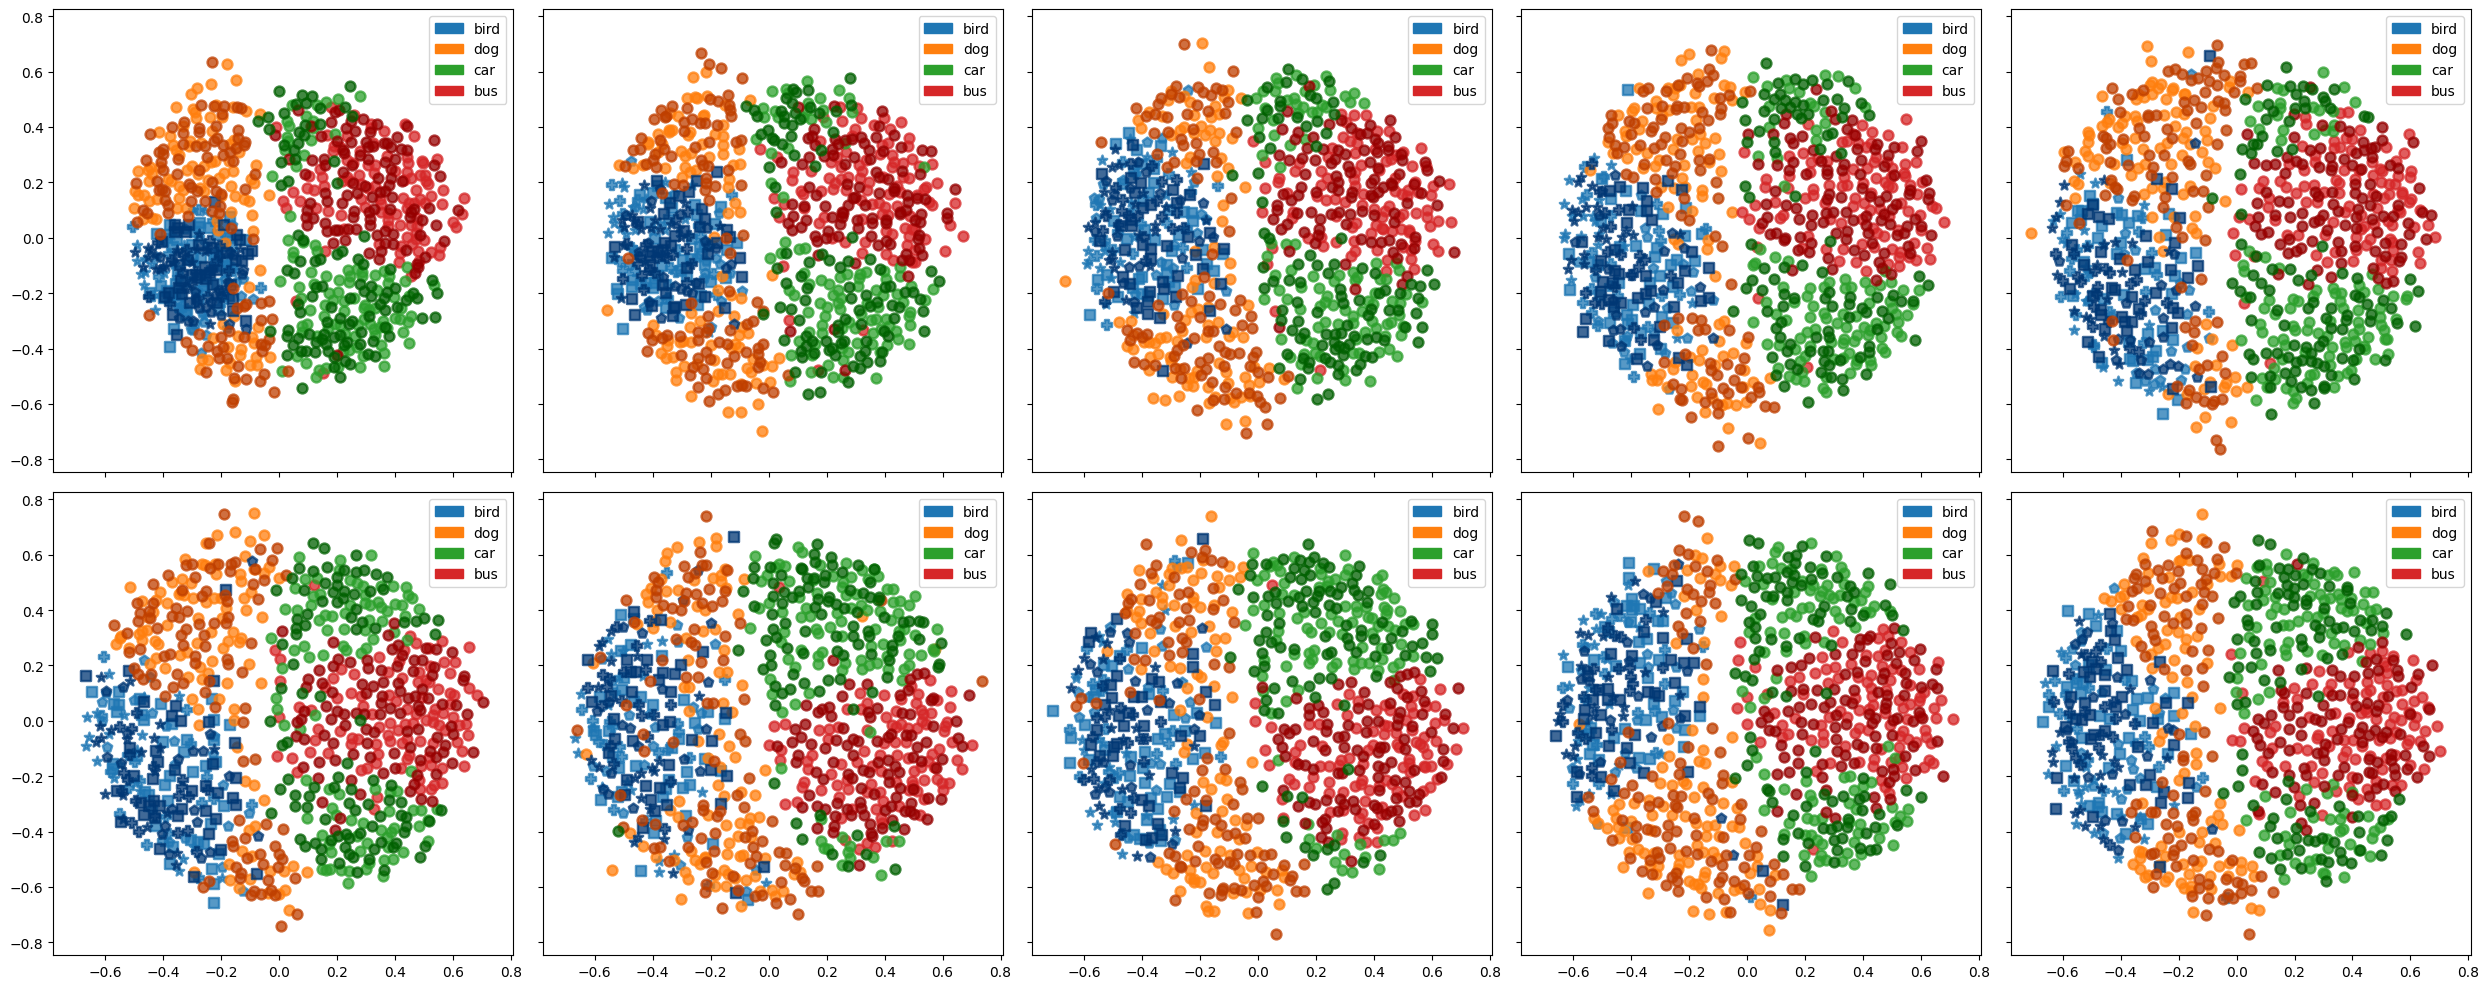

In [62]:
# Create subplot of each MDS solution
fig, ax = plt.subplots(2, 5, figsize=(25, 10), sharex=True, sharey=True)

# Plot MDS
for index in range(epochMDS.shape[0]):
    for i, row in catImgs.iterrows():
        edgecolors = None
        color = colors[i]
        if row["set"] == "test":
            color = [c - 0.25 if c - 0.25 > 0 else 0 for c in color]
            logIdx = (
                (performance["model"] == "ecoset")
                & (performance["image"] == row["name"])
                & (performance["level"] == "basic")
            )

        ax[index // 5, index % 5].scatter(
            epochMDSProc[index, i, 0],
            epochMDSProc[index, i, 1],
            s=50,
            color=color,
            marker=markers[i],
            edgecolors=edgecolors,
            alpha=0.75,
            linewidths=1.75,
        )

    legendHandles = [
        mpatches.Patch(color=colorMap["bird"], label="bird"),
        mpatches.Patch(color=colorMap["dog"], label="dog"),
        mpatches.Patch(color=colorMap["car"], label="car"),
        mpatches.Patch(color=colorMap["bus"], label="bus"),
    ]
    ax[index // 5, index % 5].legend(handles=legendHandles, loc="upper right")

# Tight layout
plt.tight_layout()